First, we complete OAuth Authentication and API setup for fine tuning a Gemini model on our data

In [2]:
import os
import google.generativeai as genai
from load_creds import load_creds, load_iam_creds

# Load credentials
creds = load_iam_creds()

# Configure generative AI with credentials
genai.configure(credentials=creds)

print()
print('Available base models:', [m.name for m in genai.list_models()])

print()
print('Available tuned models:')
try:
    tuned_models = genai.list_tuned_models()
    for i, model in enumerate(tuned_models):
        print(model.name)
        if i >= 4:  # Limit to first 5 models
            break
except Exception as e:
    print(f"Error listing tuned models: {e}")



c:\Users\jeffr\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Available base models: ['models/chat-bison-001', 'models/text-bison-001', 'models/embedding-gecko-001', 'models/gemini-1.0-pro', 'models/gemini-1.0-pro-001', 'models/gemini-1.0-pro-latest', 'models/gemini-1.0-pro-vision-latest', 'models/gemini-1.5-flash', 'models/gemini-1.5-flash-001', 'models/gemini-1.5-flash-latest', 'models/gemini-1.5-pro', 'models/gemini-1.5-pro-001', 'models/gemini-1.5-pro-latest', 'models/gemini-pro', 'models/gemini-pro-vision', 'models/embedding-001', 'models/text-embedding-004', 'models/aqa']

Available tuned models:
tunedModels/generate-num-3655
tunedModels/generate-num-optimized
tunedModels/distributed-fast-mixed


In [11]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods][0]
base_model

Model(name='models/gemini-1.0-pro-001',
      base_model_id='',
      version='001',
      display_name='Gemini 1.0 Pro 001 (Tuning)',
      description=('The best model for scaling across a wide range of tasks. This is a stable '
                   'model that supports tuning.'),
      input_token_limit=30720,
      output_token_limit=2048,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=0.9,
      max_temperature=None,
      top_p=1.0,
      top_k=None)

In [12]:
import csv

def read_csv_and_format(file_path):
    training_data = []

    with open(file_path, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            question = row['Question'].strip()
            answer = row['Answer'].strip()
            training_data.append({
                'question': question,
                'answer': answer
            })
    
    return training_data

csv_file = 'qa_datasets/distributed_complex.csv'
training_data = read_csv_and_format(csv_file)
# print(training_data)
print(f"Size: {len(training_data)}")


Size: 377


In [13]:
import random

name = f'generate-num-optimized'

# Create tuned model with SDK (epochs and batch optimized from gemini_tuning.ipynb)
operation = genai.create_tuned_model(
    source_model=base_model.name,
    training_data=training_data,
    id=name,
    epoch_count=15,
    batch_size=8,
    learning_rate=0.001,
    input_key='question', 
    output_key='answer'   
)


In [16]:
model = genai.get_tuned_model(f'tunedModels/{name}')
model

# Get state of model, irrelevant when training is complete
model.state

operation.metadata

import time
for status in operation.wait_bar():
  time.sleep(5)

100%|██████████| 707/707 [27:17<00:00,  2.32s/it]  


last mean loss: 0.5254588


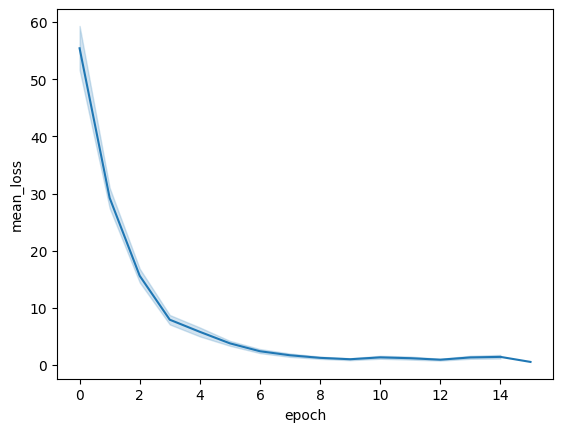

In [25]:
# Plot loss curve
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x='epoch', y='mean_loss')

last_epoch = snapshots['epoch'].max()
mean_loss_last_epoch = snapshots.loc[snapshots['epoch'] == last_epoch, 'mean_loss'].values[0]
print(f'last mean loss: {mean_loss_last_epoch}')
plt.show()


In [18]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re

model = genai.GenerativeModel(model_name=f'tunedModels/generate-num-optimized')

def preprocess_text(text):
    # Convert to lowercase and remove punctuation
    return re.sub(r'[^\w\s]', '', text.lower())

def get_relevant_passages(question, reference_text, num_passages=3, passage_length=200):
    # Preprocess the question and reference text
    processed_question = preprocess_text(question)
    processed_reference = preprocess_text(reference_text)
    
    # Split the reference text into passages
    passages = [processed_reference[i:i+passage_length] for i in range(0, len(processed_reference), passage_length)]
    
    # Create TF-IDF vectors
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(passages + [processed_question])
    
    # Calculate cosine similarity between question and passages
    cosine_similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])
    
    # Get indices of top similar passages
    top_passage_indices = cosine_similarities.argsort()[0][-num_passages:][::-1]
    
    # Return original (non-processed) passages
    return [reference_text[i*passage_length:(i+1)*passage_length] for i in top_passage_indices]

# Read reference material from file
reference_file_path = 'qa_datasets/reference.txt'
if os.path.exists(reference_file_path):
    with open(reference_file_path, 'r') as file:
        reference_material = file.read()
else:
    print(f"Warning: Reference file '{reference_file_path}' not found.")
    reference_material = ""

# Define your question
question = "What is collision resistance? Why is it relevant to cryptocurrencies?"

# Get relevant passages
relevant_passages = get_relevant_passages(question, reference_material)

# Create the full prompt
full_prompt = f"""
{question}

Relevant Reference Material:
{"".join(relevant_passages)}

Please reference the text material provided to answer this question. If the question info is not found in the reference material, pull upon your own knowledge, and add (ext) at the end of your response, otherwise if you used info from the reference, put (ref) at the end.
"""
# print(relevant_passages)
result = model.generate_content(full_prompt)

# Reformat with markdown
ans_formatted = f"{result.text}"
print(ans_formatted)

Collision resistance is a property where it is computationally infeasible to find two distinct inputs that produce the same hash output. This is relevant to cryptocurrencies because it ensures that different transactions cannot be fraudulently linked to the same hash, maintaining the integrity and security of the blockchain. (ref)


Below is a quick implementation for deploying our tuned model. I will create a Flask application and web interface, then connect the backend to our tuned Gemini model. Since Jupyter handles event loops and subprocesses differently, we will use threading to run the Flask server in the background independent of other processes. 

I've implemented two routes for now, which is all a chatbot really needs. I've included '/' for the main page, and '/chat' for handling chat message requests.

In [1]:
import random
import threading
from flask import Flask, request, jsonify, render_template_string
import google.generativeai as genai

app = Flask(__name__)

# Load your tuned model
model_name = 'your-tuned-model-id'  # Replace with your tuned model ID
model = genai.GenerativeModel(model_name=f'tunedModels/{model_name}')

@app.route('/')
def index():
    return render_template_string('''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <title>Distributed Computing Chatbot</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 50px;
                background-color: #121212;
                color: #E0E0E0;
            }
            #chatbox {
                width: 100%;
                height: 300px;
                border: 1px solid #333;
                padding: 10px;
                overflow-y: scroll;
                background-color: #1E1E1E;
                color: #E0E0E0;
            }
            .message {
                margin: 10px 0;
            }
            .user {
                text-align: right;
                color: #90CAF9;
            }
            .bot {
                text-align: left;
                color: #A5D6A7;
            }
            input[type="text"] {
                background-color: #1E1E1E;
                color: #E0E0E0;
                border: 1px solid #333;
                padding: 10px;
                width: 80%;
            }
            button {
                background-color: #333;
                color: #E0E0E0;
                border: 1px solid #555;
                padding: 10px;
            }
            button:hover {
                background-color: #444;
            }
        </style>
    </head>
    <body>
        <h1>Distributed Computing Chatbot</h1>
        <div id="chatbox"></div>
        <input type="text" id="userInput" placeholder="Type your message here">
        <button onclick="sendMessage()">Send</button>

        <script>
            function sendMessage() {
                const userInput = document.getElementById('userInput').value;
                if (userInput.trim() === '') return;

                const chatbox = document.getElementById('chatbox');
                const userMessage = document.createElement('div');
                userMessage.className = 'message user';
                userMessage.textContent = userInput;
                chatbox.appendChild(userMessage);
                document.getElementById('userInput').value = '';

                fetch('/chat', {
                    method: 'POST',
                    headers: {
                        'Content-Type': 'application/json'
                    },
                    body: JSON.stringify({ message: userInput })
                })
                .then(response => response.json())
                .then(data => {
                    const botMessage = document.createElement('div');
                    botMessage.className = 'message bot';
                    botMessage.textContent = data.response;
                    chatbox.appendChild(botMessage);
                    chatbox.scrollTop = chatbox.scrollHeight;
                })
                .catch(error => {
                    console.error('Error:', error);
                });
            }
        </script>
    </body>
    </html>
    ''')

@app.route('/chat', methods=['POST'])
def chat():
    user_input = request.json['message']
    result = model.generate_content(user_input)
    return jsonify({'response': result.text})

def run_app():
    app.run(debug=True, use_reloader=False)

# Start Flask app in a separate thread
threading.Thread(target=run_app).start()


c:\Users\jeffr\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
